In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
import tensorflow_probability as tfp
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
from functools import partial
from tqdm import tqdm_notebook as tqdm


from models import DeepConditionalModel, InvariantNetwork
from losses import maximum_likelihood_loss
from inn_utils import train_online_ml, compute_metrics
from viz import plot_losses, plot_metrics, plot_variance, plot_metrics_params

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
np.set_printoptions(suppress=True)

In [3]:
plt.rcParams['font.size'] = 14

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%matplotlib inline

In [6]:
tf.enable_eager_execution()

In [140]:
# class GaussianModelOld:
    
#     def __init__(self, d, random_state=42):
#         """
#         Implements a toy Gaussian model with:
#         """
        
#         self.d = d

        
#     def __call__(self):
#         pass
    
#     def draw_from_prior(self):
#         sigma = stats.wishart(scale=[1/self.d] * self.d).rvs()
#         mu = np.random.randn(self.d)
#         return sigma, mu
        
#     def generate_dataset(self, n_points):
        
#         # Generate data
#         sigma, mu = self.draw_from_prior()
#         x = np.random.multivariate_normal(mu, sigma, size=n_points)
#         return x, mu, sigma
            
#     def compute_posterior(self, x, sigma):
#         """
#         Computes the posterior mean given identity prior covariance and zero prior mean.
#         """
        
#         n_points = int(x.shape[0])
#         inv_sigma = np.linalg.inv(sigma)
#         inv_sigma_mu = np.identity(self.d) + n_points * inv_sigma
#         sigma_mu = np.linalg.inv(inv_sigma_mu) 
#         mu_x = n_points * sigma_mu @  inv_sigma @ np.mean(x, axis=0)
#         return mu_x, sigma_mu
    
#     def generate_multiple(self, batch_size, n_points, to_tensor=True):
#         """
#         Generates multiple MVN datasets.
#         """
        
#         X = np.zeros((batch_size, n_points, self.d))
#         theta = np.zeros((batch_size, self.d))
        
#         for bi in range(batch_size):
            
#             x, mu, sigma = self.generate_dataset(n_points)
    
#             X[bi] = x
#             theta[bi] = mu
                
#         if to_tensor:
#             X, theta = tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(theta, dtype=tf.float32)
        
#         return X, theta
    
#     def generate_with_posterior(self, batch_size, n_points, to_tensor=True):
        
#         post_means = np.zeros((batch_size, self.d))
#         post_covs = np.zeros((batch_size, self.d, self.d))
#         X = np.zeros((batch_size, n_points, self.d))
#         theta = np.zeros((batch_size, self.d))
        
#         for bi in range(batch_size):
            
#             x, mu, sigma = self.generate_dataset(n_points)
#             post_mean, post_cov = self.compute_posterior(x, sigma)
            
#             X[bi] = x
#             theta[bi] = mu
#             post_means[bi] = post_mean
#             post_covs[bi] = post_cov
            
#         if to_tensor:
#             X, theta = tf.convert_to_tensor(X, dtype=tf.float32), tf.convert_to_tensor(theta, dtype=tf.float32)
#         return X, theta, post_means, post_covs

In [141]:
class GaussianModel:
    
    def __init__(self, d, random_state=42):
        """
        Implements a toy Gaussian model.
        """
        

        self.d = d
        sigma = stats.wishart.rvs(d, scale=np.identity(d) / d, random_state=random_state)
        self.sigma = tf.convert_to_tensor(sigma, dtype=tf.float32)
        self.inv_sigma = tf.linalg.inv(self.sigma)
        self.inv_sigma_mu = tf.eye(d) + self.inv_sigma
        self.sigma_mu = tf.linalg.inv(self.inv_sigma_mu) 
        
        
    def __call__(self, batch_size):
        
        return self.generate_datasets(batch_size)
    
    def generate_datasets(self, batch_size, return_cov=False):
        
        mu_x = tf.random_normal(shape=(batch_size, self.d))
        sigma_x = self.sigma
        x = tfp.distributions.MultivariateNormalFullCovariance(mu_x, sigma_x).sample()
        
        if return_cov:
            return x, mu_x, sigma_x
        return x, mu_x
    
    def compute_posterior(self, batch_size, x, sigma_x):
        """
        Computes the posterior mean given identity prior covariance and zero prior mean.
        x is a batch of means
        cov_x is a batch of covariance matrices
        """
        
        mu_p = tf.matmul(tf.matmul(self.sigma_mu, self.inv_sigma), tf.transpose(x))
        mu_p = tf.transpose(mu_p)
                         
        return mu_p, self.sigma_mu

    def generate_with_posterior(self, batch_size):
        
        x, mu_x, sigma_x = self.generate_datasets(batch_size, return_cov=True)
        mu_p, sigma_p = self.compute_posterior(batch_size, x, sigma_x)
        return x, mu_x, mu_p, sigma_p
    
    def KL(self, mu_true, sigma_true, mu_hat, sigma_hat):
        """
        Computes the KL divergence between two Gaussians.
        """
        
        d = int(mu_true.shape[1])
        inv_sigma_hat = tf.linalg.inv(sigma_hat)
        mu_diff = mu_hat - mu_true
        kl = tf.log1p(tf.linalg.det(sigma_hat)) - tf.log1p(tf.linalg.det(sigma_true))
        kl -= d
        kl += tf.linalg.trace(tf.matmul(inv_sigma_hat, sigma_true))
        kl += tf.einsum('mj,mj->m',tf.einsum('mi,mij->mj', mu_diff, inv_sigma_hat), mu_diff)
        kl *= 0.5
        return max(tf.reduce_mean(kl), 0)

# 5-D Gaussian

In [173]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
theta_dim = 5
params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 25
iterations_per_epoch = 1000
n_inv_blocks = 3
n_points = 1000
n_test = 100
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .99
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

In [174]:
# ----- Data generation function----- 
mvn_gaussian = GaussianModel(theta_dim)

In [175]:
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [176]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/gaussian_5d', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/gaussian_5d\ckpt-6


In [177]:
X_test, theta_test, theta_p, sigma_p = mvn_gaussian.generate_with_posterior(n_test)
sigma_p = tf.stack([sigma_p] * n_test, axis=0)

## Plot recovery of untrained network

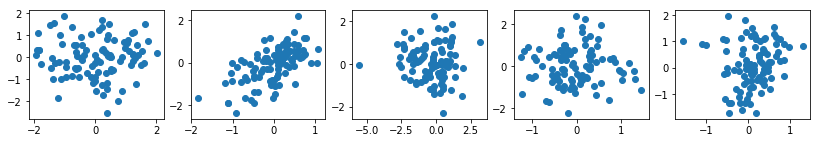

In [157]:
samples = tf.reduce_mean(model.sample(X_test, n_samples_posterior), 0)
f, ax = plt.subplots(1, 5, figsize=(14, 2))
for i in range(5):
    ax.flat[i].scatter(samples[:, i], theta_p[:, i])

## Plot posteriors

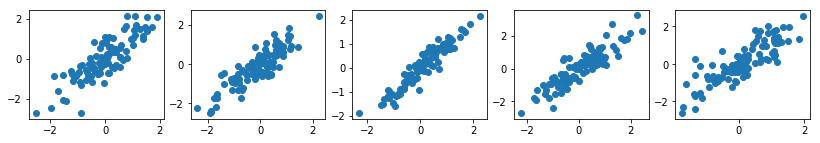

In [159]:
# Plot posteriors vs test
f, ax = plt.subplots(1, 5, figsize=(14, 2))
for i in range(5):
    ax.flat[i].scatter(theta_p[:, i], theta_test[:, i])

## Train the model

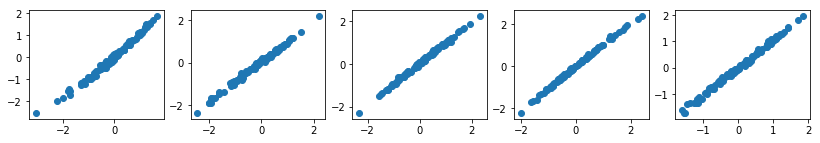

KL:  tf.Tensor(0.10084254, shape=(), dtype=float32)



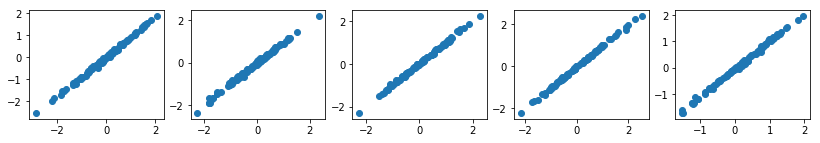

KL:  tf.Tensor(0.016686713, shape=(), dtype=float32)



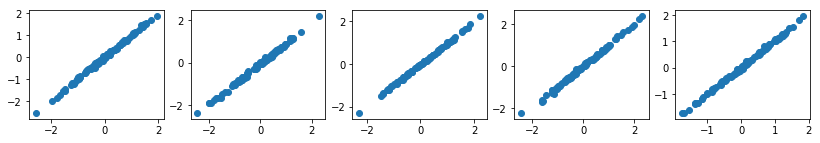

KL:  tf.Tensor(0.042135324, shape=(), dtype=float32)
Instructions for updating:
Use standard file APIs to delete files with this prefix.



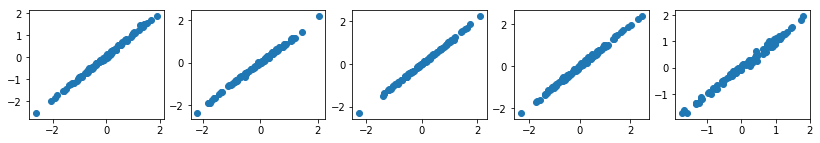

KL:  tf.Tensor(0.05771822, shape=(), dtype=float32)



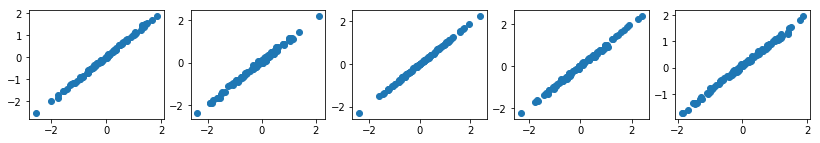

KL:  tf.Tensor(0.098290026, shape=(), dtype=float32)



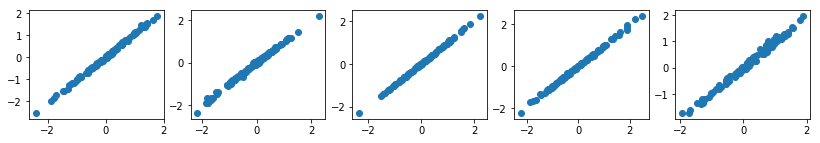

KL:  0



KeyboardInterrupt: 

In [160]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
        # Run training loop
        train_online_ml(model, optimizer, mvn_gaussian, iterations_per_epoch, 
                        batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
                        transform=None, n_smooth=100)
        
        # Test performance
        samples = model.sample(X_test, n_samples_posterior)
        samples_mean = tf.reduce_mean(samples, axis=0)
        samples_cov = tfp.stats.covariance(samples, sample_axis=0)
        f, ax = plt.subplots(1, 5, figsize=(14, 2))
        for i in range(theta_dim):
            ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
        plt.show()

        # Test KL
        print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov))

        # Save model
        manager.save()

## Evaluate performance

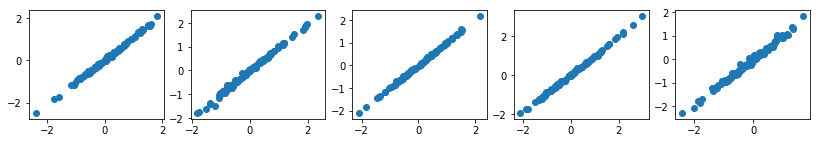

KL:  0


In [178]:
# Test performance
samples = model.sample(X_test, n_samples_posterior)
samples_mean = tf.reduce_mean(samples, axis=0)
samples_cov = tfp.stats.covariance(samples, sample_axis=0)
f, ax = plt.subplots(1, 5, figsize=(14, 2))
for i in range(5):
    ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
plt.show()

# Test KL
print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov))

# 50-D Gaussian

In [179]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [128, 128, 128],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
train = False
theta_dim = 50
params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 3
n_points = 1000
n_test = 100
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 5000
decay_rate = .99
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)


# ----- Data generation function----- 
mvn_gaussian = GaussianModel(theta_dim)

In [180]:
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [181]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/gaussian_50d', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [182]:
X_test, theta_test, theta_p, sigma_p = mvn_gaussian.generate_with_posterior(n_test)
sigma_p = tf.stack([sigma_p] * n_test, axis=0)

## Plot recovery of untrained network

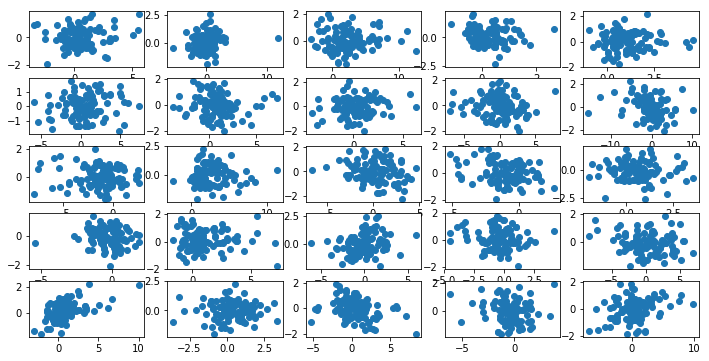

In [183]:
samples = tf.reduce_mean(model.sample(X_test, n_samples_posterior), 0)
f, ax = plt.subplots(5, 5, figsize=(12, 6))
for i in range(25):
    ax.flat[i].scatter(samples[:, i], theta_p[:, i])

## Plot posteriors

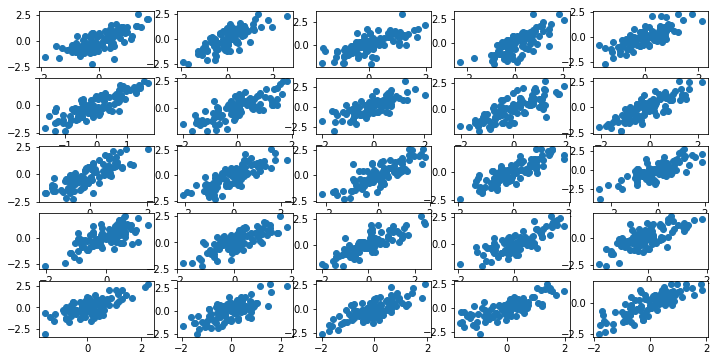

In [184]:
# Plot posteriors vs test
f, ax = plt.subplots(5, 5, figsize=(12, 6))
for i in range(25):
    ax.flat[i].scatter(theta_p[:, i], theta_test[:, i])

## Train

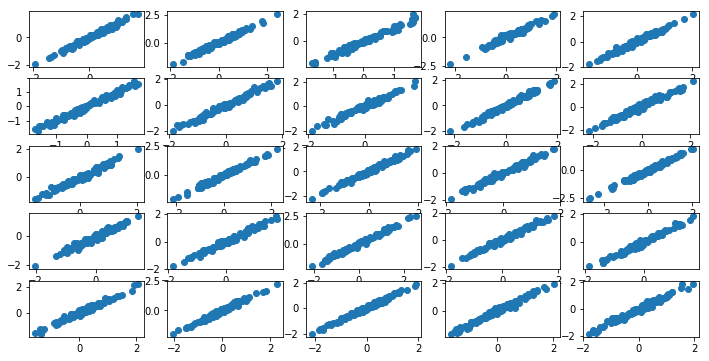

KL:  0.41072816



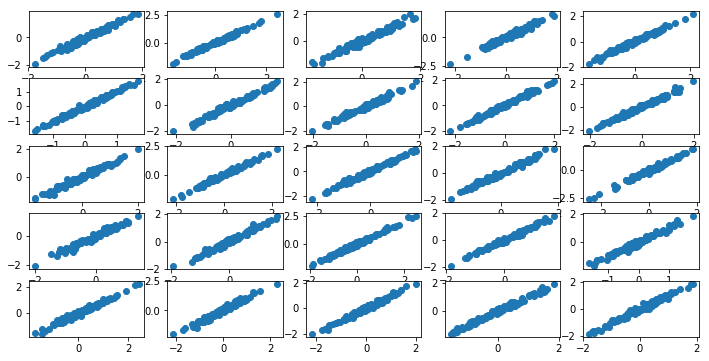

KL:  0.3556069



KeyboardInterrupt: 

In [193]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
        # Run training loop
        train_online_ml(model, optimizer, mvn_gaussian, iterations_per_epoch, 
                        batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
                        transform=None, n_smooth=100)
        
        # Test performance
        samples = model.sample(X_test, n_samples_posterior)
        samples_mean = tf.reduce_mean(samples, axis=0)
        samples_cov = tfp.stats.covariance(samples, sample_axis=0)
        f, ax = plt.subplots(5, 5, figsize=(12, 6))
        for i in range(25):
            ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
        plt.show()

        # Test KL
        print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov).numpy())

        # Save model
        manager.save()

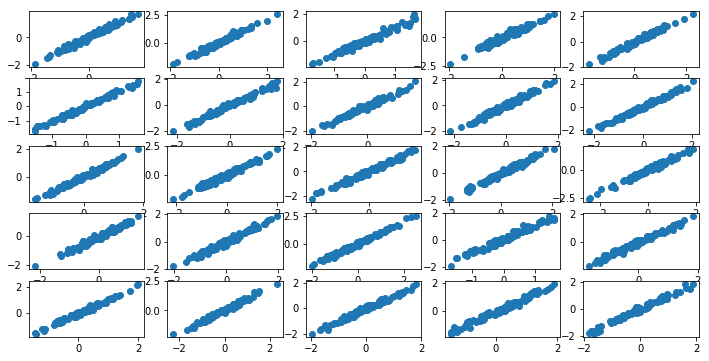

KL:  tf.Tensor(1.2177248, shape=(), dtype=float32)


In [192]:
samples = model.sample(X_test, n_samples_posterior)
samples_mean = tf.reduce_mean(samples, axis=0)
samples_cov = tfp.stats.covariance(samples, sample_axis=0)
f, ax = plt.subplots(5, 5, figsize=(12, 6))
for i in range(25):
    ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
plt.show()

# Test KL
print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov))

# 500-D Gaussian

In [210]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [512, 512, 512],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
theta_dim = 500
params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 3
n_test = 100
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

In [211]:
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [212]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/gaussian_500d', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [213]:
# ----- Data generation function----- 
mvn_gaussian = GaussianModel(theta_dim)

In [214]:
X_test, theta_test, theta_p, sigma_p = mvn_gaussian.generate_with_posterior(n_test)
sigma_p = tf.stack([sigma_p] * n_test, axis=0)

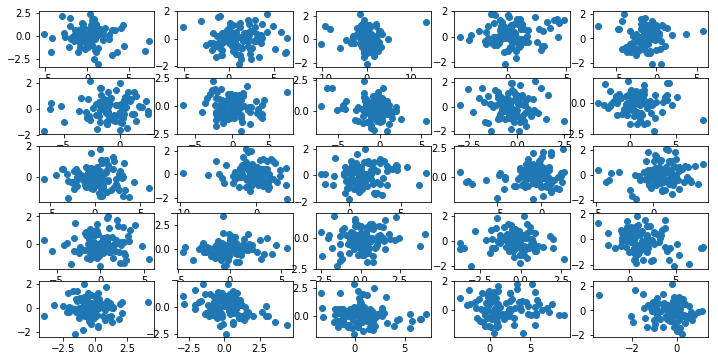

In [215]:
samples = tf.concat([model.sample(X_test, 200) for _ in range(20)], axis=0)
samples = tf.reduce_mean(samples, axis=0)
f, ax = plt.subplots(5, 5, figsize=(12, 6))
for i in range(25):
    ax.flat[i].scatter(samples[:, i], theta_p[:, i])

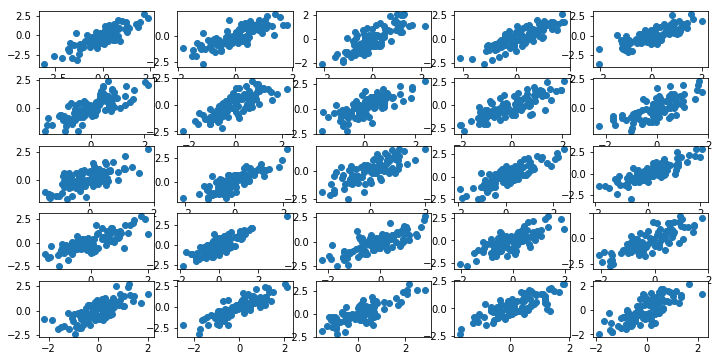

In [216]:
# Plot posteriors vs test
f, ax = plt.subplots(5, 5, figsize=(12, 6))
for i in range(25):
    ax.flat[i].scatter(theta_p[:, i], theta_test[:, i])

## Train

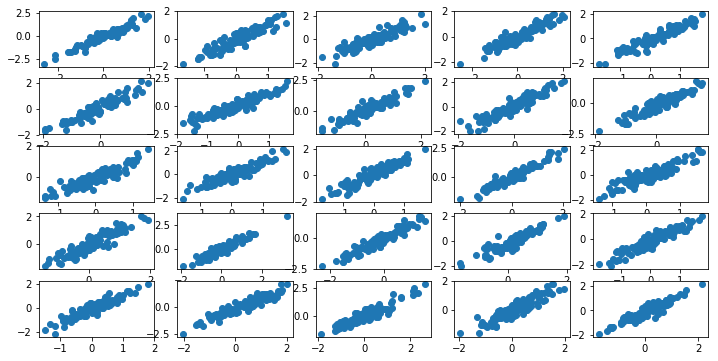

KL:  42.55996



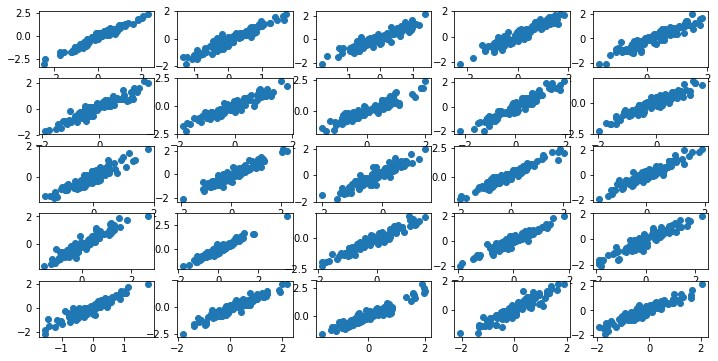

KL:  44.047043



KeyboardInterrupt: 

In [217]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
        # Run training loop
        train_online_ml(model, optimizer, mvn_gaussian, iterations_per_epoch, 
                        batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
                        transform=None, n_smooth=100)
        
        # Test performance
        samples = tf.concat([model.sample(X_test, 200) for _ in range(20)], axis=0)
        samples_mean = tf.reduce_mean(samples, axis=0)
        samples_cov = tfp.stats.covariance(samples, sample_axis=0)
        f, ax = plt.subplots(5, 5, figsize=(12, 6))
        for i in range(25):
            ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
        plt.show()

        # Test KL
        print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov).numpy())

        # Save model
        manager.save()

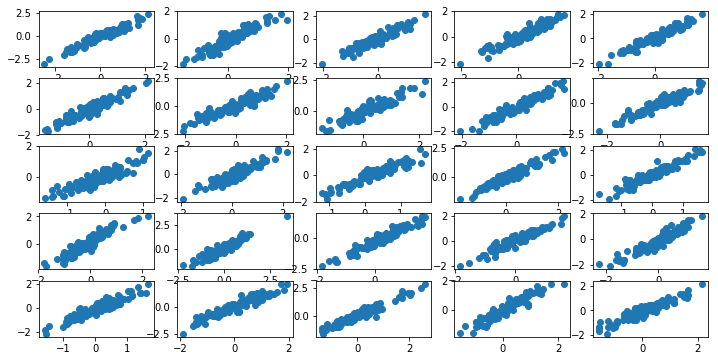

KL:  41.68307


In [218]:
# Test performance
samples = tf.concat([model.sample(X_test, 200) for _ in range(20)], axis=0)
samples_mean = tf.reduce_mean(samples, axis=0)
samples_cov = tfp.stats.covariance(samples, sample_axis=0)
f, ax = plt.subplots(5, 5, figsize=(12, 6))
for i in range(25):
    ax.flat[i].scatter(samples_mean[:, i], theta_p[:, i])
plt.show()

# Test KL
print('KL: ', mvn_gaussian.KL(theta_p, sigma_p, samples_mean, samples_cov).numpy())

# 5000-d Gaussian

In [220]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [1024, 1024, 1024],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
theta_dim = 5000
params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 3
n_test = 100
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

In [221]:
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [ ]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/gaussian_5000d', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

In [ ]:
# ----- Data generation function----- 
mvn_gaussian = GaussianModel(theta_dim)

In [ ]:
X_test, theta_test, theta_p, sigma_p = mvn_gaussian.generate_with_posterior(n_test)
sigma_p = tf.stack([sigma_p] * n_test, axis=0)

# Misc

In [2]:
# Attemp a mixture of Gaussians

In [91]:
def mixture_of_gaussians(batch_size, one_hot=True):
    
    # Clockwise means
    means = np.array([
        [0, 6],
        [3.0, 3.0],
        [6, 0],
        [3.0, -3.0],
        [0, -6],
        [-3, -3],
        [-6.0, 0.0],
        [-3.0, 3.0]
    ])
    
    indices = np.random.choice(np.random.permutation(8), size=batch_size, replace=True)
    samples = np.array([np.random.multivariate_normal(means[idx], np.identity(2)/2) for idx in indices])
    indices[indices==0] = 0
    indices[indices==1] = 0
    indices[indices==2] = 0
    indices[indices==3] = 0
    indices[indices==4] = 1
    indices[indices==5] = 1
    indices[indices==6] = 2
    indices[indices==7] = 3
    if one_hot:
        indices = tf.keras.utils.to_categorical(indices)
    
    return tf.convert_to_tensor(indices, dtype=tf.float32), tf.convert_to_tensor(samples, dtype=tf.float32)

In [103]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}

# --- Training hyperparameters --- #
theta_dim = 2
params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_inv_blocks = 4
n_test = 100
n_test2 = 3
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

In [104]:
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

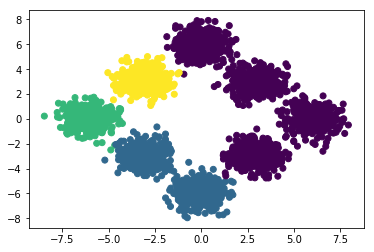

In [105]:
X_test, theta_test = mixture_of_gaussians(3000)
X_idx = tf.argmax(X_test, axis=1)
plt.scatter(theta_test[:, 0], theta_test[:, 1], c=X_idx)

In [106]:
def test_gmm(model):
    
    X_test = tf.keras.utils.to_categorical(np.array([0, 1, 2, 3]))
    samples_theta = model.sample(X_test, n_samples_posterior).numpy()
    
    samples_theta_x1 = np.concatenate([
        samples_theta[:, 0, 0],
        samples_theta[:, 1, 0],
        samples_theta[:, 2, 0],
        samples_theta[:, 3, 0],
    ])

    samples_theta_x2 = np.concatenate([
        samples_theta[:, 0, 1],
        samples_theta[:, 1, 1],
        samples_theta[:, 2, 1],
        samples_theta[:, 3, 1],
    ])

    idx = np.repeat([0, 1, 2, 3], n_samples_posterior)

    plt.scatter(samples_theta_x1, samples_theta_x2, c=idx)
    plt.show()

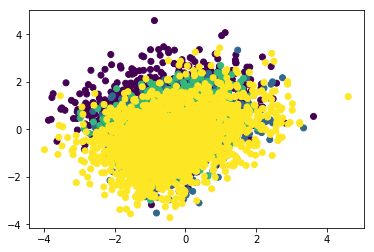

In [107]:
test_gmm(model)

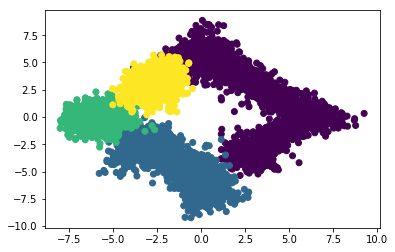

KeyboardInterrupt: 

In [108]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        
        # Run training loop
        train_online_ml(model, optimizer, mixture_of_gaussians, iterations_per_epoch, 
                        batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
                        transform=None, n_smooth=100)
        
        # Test performance
        test_gmm(model)